In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import GATConv, global_mean_pool
from minisom import MiniSom  
import numpy as np
from torch_geometric.loader import NeighborLoader
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import umap
from torch_geometric.nn import GATConv
import torch.distributions as D


In [2]:
import sys
sys.path.append('/home/mei/nas/docker/thesis')
from dataloader.ts_reader import LSTMTSDataset,collate_fn
from dataloader.pyg_reader import GraphDataset

In [3]:
# Encoder 部分：对每个时间步输入进行编码，输出均值和对数方差
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim, dropout=0.5):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_channels, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 2000)
        self.fc_mu = nn.Linear(2000, latent_dim)
        self.fc_sigma = nn.Linear(2000, latent_dim)  # 输出 logvar（对数方差）
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(500)
        self.bn2 = nn.BatchNorm1d(500)
        self.bn3 = nn.BatchNorm1d(2000)

    def forward(self, x):
        # x: [batch_size * seq_len, input_channels]
        h1 = F.leaky_relu(self.fc1(x))
        h1 = self.dropout(h1)
        h1 = self.bn1(h1)
        h2 = F.leaky_relu(self.fc2(h1))
        h2 = self.dropout(h2)
        h2 = self.bn2(h2)
        h3 = F.leaky_relu(self.fc3(h2))
        h3 = self.dropout(h3)
        h3 = self.bn3(h3)
        mu = self.fc_mu(h3)
        logvar = self.fc_sigma(h3)
        return mu, logvar


In [4]:
# Decoder 部分：从 latent 向量重构输入，返回一个 Distribution 对象
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels, dropout=0.5):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 2000)
        self.fc2 = nn.Linear(2000, 500)
        self.fc3 = nn.Linear(500, 500)
        self.fc_out = nn.Linear(500, output_channels)
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(2000)
        self.bn2 = nn.BatchNorm1d(500)
        self.bn3 = nn.BatchNorm1d(500)

    def forward(self, z):
        # z: [batch_size * seq_len, latent_dim]
        h1 = F.leaky_relu(self.fc1(z))
        h1 = self.bn1(h1)
        h2 = F.leaky_relu(self.fc2(h1))
        h2 = self.bn2(h2)
        h3 = F.leaky_relu(self.fc3(h2))
        h3 = self.bn3(h3)
        # 输出重构均值，假定标准差固定为 1
        out = self.fc_out(h3)
        std = torch.ones_like(out)
        dist = D.Independent(D.Normal(out, std), 1)
        return dist


In [5]:
# PredictionModule 部分：利用 LSTM 对时序 latent 表示进行建模，预测下一状态
class PredictionModule(nn.Module):
    def __init__(self, latent_dim, lstm_dim, dropout=0.5):
        super(PredictionModule, self).__init__()
        self.lstm = nn.LSTM(latent_dim, lstm_dim, batch_first=True)
        self.fc_out = nn.Linear(lstm_dim, latent_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, z_seq):
        # z_seq: [batch_size, seq_len, latent_dim]
        lstm_out, _ = self.lstm(z_seq)  # 输出: [batch_size, seq_len, lstm_dim]
        lstm_out = self.dropout(lstm_out)
        pred = self.fc_out(lstm_out)    # [batch_size, seq_len, latent_dim]
        return pred # 返回预测的 latent 表示

In [6]:
class TempDPSOM(nn.Module):
    def __init__(self, input_channels=454, latent_dim=128, lstm_dim=128, dropout=0.5, pad_value=-9999, som_dim=(24,24)):
        """
        Args:
            input_channels: 每个时间步的特征数
            latent_dim: 潜在空间维度
            lstm_dim: LSTM 隐层维度
            dropout: dropout 比例
            pad_value: 用于 padding -9999
            som_dim: SOM 网格尺寸，例如 (24, 24)
        """
        super(TempDPSOM, self).__init__()
        self.input_channels = input_channels
        self.latent_dim = latent_dim
        self.lstm_dim = lstm_dim
        self.pad_value = pad_value
        self.som_dim = som_dim

        self.encoder = Encoder(input_channels, latent_dim, dropout)
        self.decoder = Decoder(latent_dim, input_channels, dropout)
        self.prediction = PredictionModule(latent_dim, lstm_dim, dropout)


        # shape: [som_dim[0], som_dim[1], latent_dim]
        self.som_embeddings = nn.Parameter(torch.randn(som_dim[0], som_dim[1], latent_dim) * 0.05)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        """
        Args:
            x: input tensor:  [batch_size, seq_len, input_channels]
        Returns:
            recon: reconstruction distri,shape [batch_size * seq_len, input_channels]
            z_seq: latent of time series data, shape[batch_size, seq_len, latent_dim]
            pred: LSTM predict output,shape [batch_size, seq_len, latent_dim]
            som_coords: the coordinate of each time step: [batch_size, seq_len, 2]
        """
        batch_size, seq_len, input_channels = x.size()

        # 1. 保留真实数据，将 padding 部分不替换为0，而是构造 mask（这里为了 encoder 计算，将 padding 替换为0）
        # 注意：为了不混淆真实数据和 padding，后续计算 loss 时应利用 mask
        
        x_processed = x.clone()
        x_processed[x_processed == self.pad_value] = 0.0
        # print(f"x_processed shape before view: {x_processed.shape}") # [batch_size, seq_len, input_channels]
        
        # 2. Flatten 输入: [batch_size * seq_len, input_channels]
        x_flat = x_processed.view(batch_size * seq_len, input_channels)    # [batch_size * seq_len, input_channels]
        # Encoder：计算 latent 分布并采样
        mu, logvar = self.encoder(x_flat)
        z_sample = self.reparameterize(mu, logvar)
        
        # 3. Decoder：重构输入
        recon = self.decoder(z_sample)  # Distribution 对象
        # 4. 恢复时序 latent 表示: [batch_size, seq_len, latent_dim]
        z_seq = z_sample.view(batch_size, seq_len, self.latent_dim)
        # 5. Prediction：利用 LSTM 进行时序预测
        pred = self.prediction(z_seq)   # [batch_size, seq_len, latent_dim]

        # 6. SOM 部分：计算每个时间步的 SOM 坐标（矢量化计算）
        # 将 z_seq 展平: [batch_size*seq_len, latent_dim]
        z_flat_som = z_seq.view(-1, self.latent_dim)
        # 将 SOM embeddings 展平: [som_dim[0]*som_dim[1], latent_dim]
        som_emb_flat = self.som_embeddings.view(-1, self.latent_dim)
        # 计算欧氏距离： [N, M]
        dists = torch.cdist(z_flat_som, som_emb_flat, p=2)
        # 对每个 latent 向量找到最近的 SOM 节点索引: [N]
        indices = torch.argmin(dists, dim=1)
        # 将索引转换为二维坐标：假设网格形状为 (som_dim[0], som_dim[1])
        som_x = (indices // self.som_dim[1]).float()
        som_y = (indices % self.som_dim[1]).float()
        som_coords_flat = torch.stack([som_x, som_y], dim=1)  # [N, 2]
        # 重塑为 [batch_size, seq_len, 2]
        som_coords = som_coords_flat.view(batch_size, seq_len, 2)

        # mu 和 logvar 返回，用于计算 KL 损失
        return recon, z_seq, pred, som_coords, mu, logvar


In [7]:
# 1. 静态数据处理模块：简单的 MLP
class FlatModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=163, out_dim=163):
        super(FlatModule, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        # x: [batch_size, flat_dim]
        return self.fc(x)  # 输出：[batch_size, out_dim]

In [8]:
# class GraphModule(nn.Module):
#     def __init__(self, in_channels, hidden_channels=163, out_channels=163, num_layers=2):
#         super(GraphModule, self).__init__()
#         self.convs = nn.ModuleList()
#         self.convs.append(GATConv(in_channels, hidden_channels, heads=4, concat=True))
#         for _ in range(num_layers-2):
#             self.convs.append(GATConv(hidden_channels*4, hidden_channels, heads=4, concat=True))
#         self.convs.append(GATConv(hidden_channels*4, out_channels, heads=1, concat=False))
#     def forward(self, x, edge_index, batch):
#         # x: [num_nodes, in_channels]
#         # edge_index: [2, num_edges]
#         # batch: [num_nodes] 指明每个节点属于哪个图
#         for conv in self.convs:
#             x = F.elu(conv(x, edge_index))
#         # 全局池化，每个图得到一个 embedding
#         x = global_mean_pool(x, batch)  # [num_graphs, out_channels]
#         return x

In [8]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, num_classes=2):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        # x: [batch_size, in_dim]
        return self.fc(x)

In [9]:
class MultiModalModel(nn.Module):
    def __init__(self, flat_dim, ts_input_dim, graph_in_dim,
                 latent_dim=128, lstm_hidden=128, som_dim=(24,24),
                 num_classes=5, dropout=0.5):
        super(MultiModalModel, self).__init__()
        #process flat data
        self.flat_module = FlatModule(flat_dim)
    
        # process graph data
        self.gnn = GraphSAGE(graph_in_dim, latent_dim, num_layers=2)  
                
        self.fusion_dim = 454
        
        # 时序数据处理模块（lab test 和 vital signs）
        self.ts_module = TempDPSOM(input_channels=454, latent_dim=latent_dim, lstm_dim=lstm_hidden,
                                   dropout=dropout, pad_value=-9999, som_dim=som_dim)
        
        self.classifier = Classifier(in_dim=2, hidden_dim=32, num_classes=num_classes)
    
    def forward(self, flat, ts, graph_data):
        """
        Args:
          flat: 静态数据, [batch_size, flat_dim]
          ts: 时序数据, [batch_size, seq_len, ts_input_dim]
          graph_data: 图数据, [batch_size, graph_in_dim] 
        Returns:
          logits: 分类器输出, [batch_size, num_classes]
          som_coords: SOM 层输出的二维坐标, [batch_size, seq_len, 2]
          fusion_features: 融合后的特征, [batch_size, fusion_dim]
        """
        # 处理各模态数据
        flat_feat = self.flat_module(flat)             # [batch_size, 128]
        graph_feat = self.gnn(graph_data.x, graph_data.edge_index)    # [num_graphs, latent_dim]
        # ts_feat = self.lstm(ts)  # [batch_size, seq_len, lstm_hidden]
                                            
        # print(f"flat_feat shape: {flat_feat.shape}")
        # print(f"ts shape: {ts.shape}")
        # print(f"graph_feat shape: {graph_feat.shape}")
        
         # 融合：简单拼接 flat 特征、时序特征和图特征
        flat_feat = flat_feat.unsqueeze(1).expand(-1, ts.shape[1], -1)
        graph_feat  = graph_feat .unsqueeze(1).expand(-1, ts.shape[1], -1)    # [batch_size, seq_len, hidden_dim]
        fusion_features = torch.cat([ts, flat_feat, graph_feat], dim=-1)     # [batch_size, seq_len, hidden_dim]
        print(f"fusion_features shape: {fusion_features.shape}")
        
        recon, z_seq, pred, som_coords, mu, logvar = self.ts_module(fusion_features)

       
        # 对于分类，可以选择：
        # Option 1：直接对 SOM 坐标取平均作为最终特征
        som_mean = som_coords.mean(dim=1)  # [batch_size, 2]
        # Option 2：拼接 SOM 坐标和融合特征，再输入分类器（这里简单使用 Option 1）
        logits = self.classifier(som_mean)  # [batch_size, num_classes]
        
        # ts_feat = z_seq[:, -1, :]
        # fusion_features = torch.cat([flat_feat, ts_feat, graph_feat], dim=1)  # [batch_size, fusion_dim]
        # logits = self.classifier(fusion_features)
        
        return logits, som_coords, fusion_features, recon, z_seq, pred, mu, logvar

In [10]:
import torch.nn.functional as F

def loss_function(x, recon, mu, logvar, pred, z_seq,labels,logits, pad_value=-9999):
    """
    计算总损失
      1. 重构损失(MSE):计算 decoder 输出（重构均值）与原始输入之间的均方误差，
         同时利用 mask 排除 padding 部分
      2. KL 散度损失：约束 encoder 输出的分布接近标准正态分布。
      3. 预测损失：计算 LSTM 预测的 latent 与真实下一时刻 latent(通过 z_seq 后移构造）之间的均方误差。
    
    Args:
      x: 原始输入, [batch_size, seq_len, input_channels]
      recon: decoder 输出的 Distribution 对象（重构分布）
      mu, logvar: Encoder 输出, 形状 [batch_size*seq_len, latent_dim]
      pred: Prediction 模块输出, 形状 [batch_size, seq_len, latent_dim]
      z_seq: 真实的 latent 时序表示, 形状 [batch_size, seq_len, latent_dim]
      pad_value: 填充值
      
    Returns:
      total_loss, recon_loss, kl_loss, pred_loss
    """
    batch_size, seq_len, input_channels = x.size()
    # 提取 decoder 输出的均值作为重构结果
    recon_mean = recon.mean  # shape: [batch_size*seq_len, input_channels]
    
    # 将原始输入 x 平铺为 [batch_size*seq_len, input_channels]
    x_flat = x.view(-1, input_channels)
    # 使用重构均值进行重构损失计算
    recon_flat = recon_mean  # already flattened shape: [batch_size*seq_len, input_channels]
    
    # 构造 mask：如果某时间步所有特征均为 pad_value，则认为该位置无效
    mask = (x_flat != pad_value).any(dim=1).float().unsqueeze(1)  # [batch_size*seq_len, 1]
    
    recon_loss = F.mse_loss(recon_flat * mask, x_flat * mask)
    
    # KL 散度损失（Gaussian KL 散度公式）
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / (batch_size * seq_len)
    
    # 预测损失：将 z_seq 向左平移一位作为真实下一时刻 latent
    z_next = torch.cat([z_seq[:, 1:, :], z_seq[:, -1:, :]], dim=1)
    pred_loss = F.mse_loss(pred, z_next)
    
    cls_loss = nn.CrossEntropyLoss()(logits, labels)
    
    total_loss = recon_loss + kl_loss + pred_loss + cls_loss
    return total_loss, recon_loss, kl_loss, pred_loss,cls_loss



In [13]:

data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3
          
}

lstm_dataset = LSTMTSDataset(data_dir,debug=False)
lstm_loader = DataLoader(lstm_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, pin_memory=True)

graph_dataset = GraphDataset(config)
graph_data = graph_dataset.graph_data  #
graph_data.edge_index = graph_data.edge_index.contiguous() 

# `NeighborLoader` 进行采样
graph_loader = NeighborLoader(
    graph_data,
    num_neighbors=[10, 10],  # 2-hop 采样，每层 10 个邻居
    batch_size=64,
    shuffle=True
)

==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5
x_flat shape: torch.Size([11698, 104]), num_nodes: 11698


In [14]:
num_epochs=1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiModalModel(flat_dim=104, ts_input_dim=163, graph_in_dim=104,
                            latent_dim=128, lstm_hidden=128, som_dim=(24,24),
                            num_classes=5, dropout=0.5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(2):
    epoch_loss = 0.0
    for ((flat, ts, seq_lengths), labels, ids), graph_data in zip(lstm_loader, graph_loader):
        flat, ts, labels, graph_data = flat.to(device), ts.to(device), labels.to(device), graph_data.to(device)
        
        optimizer.zero_grad()
        logits, som_coords, fusion_features, recon, z_seq, pred, mu, logvar = model(flat, ts, graph_data)
        
        total_loss, recon_loss, kl_loss, pred_loss,cls_loss = loss_function(fusion_features, recon, mu, logvar, pred, z_seq,labels,logits, pad_value=-9999)
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    print(f"Epoch {epoch+1}, Total Loss: {epoch_loss/len(lstm_loader):.4f}")

fusion_features shape: torch.Size([64, 3999, 454])


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.70 GiB. GPU 0 has a total capacity of 23.46 GiB of which 2.21 GiB is free. Process 804972 has 250.00 MiB memory in use. Including non-PyTorch memory, this process has 21.00 GiB memory in use. Of the allocated memory 20.75 GiB is allocated by PyTorch, and 50.32 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
save_path = '/home/mei/nas/docker/thesis/data/logs/model.pth' 
torch.save(model.state_dict(), save_path)

logits.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/logits.npy', logits)
som_coords.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/som_coords.npy', som_coords)
fusion_features.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/fusion_features.npy', fusion_features)
recon.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/recon.npy', recon)
z_seq.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/z_seq.npy', z_seq)
pred.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/pred.npy', pred)
mu.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/mu.npy', mu)
logvar.cpu().detach().numpy()
np.save('/home/mei/nas/docker/thesis/data/ray_results/logvar.npy', logvar)


In [20]:
import matplotlib.pyplot as plt

# 假设 som_coords 的形状为 [batch_size, seq_len, 2]
# 这里我们取 batch 中第一个样本的 SOM 坐标
som_coords_np = som_coords[0].detach().cpu().numpy()  # shape: [seq_len, 2]

plt.figure(figsize=(6, 6))
plt.scatter(som_coords_np[:, 0], som_coords_np[:, 1], c=range(som_coords_np.shape[0]), cmap='viridis')
plt.colorbar(label="Time step")
plt.xlabel("SOM Grid X")
plt.ylabel("SOM Grid Y")
plt.title("cluster result")
plt.grid(True)
plt.show()

NameError: name 'som_coords' is not defined

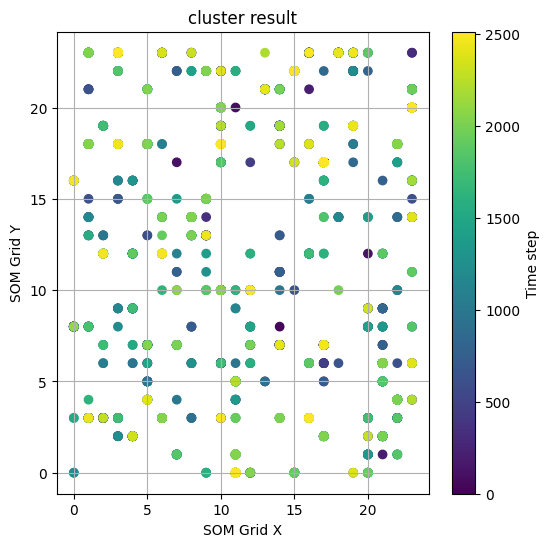

In [17]:
import matplotlib.pyplot as plt

# 假设 som_coords 的形状为 [batch_size, seq_len, 2]
# 这里我们取 batch 中第一个样本的 SOM 坐标
som_coords_np = som_coords[0].detach().cpu().numpy()  # shape: [seq_len, 2]

plt.figure(figsize=(6, 6))
plt.scatter(som_coords_np[:, 0], som_coords_np[:, 1], c=range(som_coords_np.shape[0]), cmap='viridis')
plt.colorbar(label="Time step")
plt.xlabel("SOM Grid X")
plt.ylabel("SOM Grid Y")
plt.title("cluster result")
plt.grid(True)
plt.show()

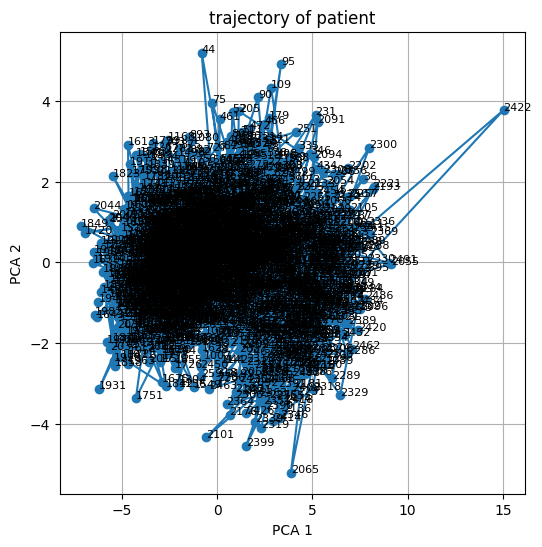

In [19]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 假设 z_seq 的形状为 [batch_size, seq_len, latent_dim]
# 这里取第一个样本的 z_seq
z_seq_sample = z_seq[0].detach().cpu().numpy()  # shape: [seq_len, latent_dim]

# 使用 PCA 将 latent 表示降维到 2 维
pca = PCA(n_components=2)
z_seq_2d = pca.fit_transform(z_seq_sample)  # shape: [seq_len, 2]

plt.figure(figsize=(6, 6))
plt.plot(z_seq_2d[:, 0], z_seq_2d[:, 1], marker='o', linestyle='-')
for i, (x_val, y_val) in enumerate(z_seq_2d):
    plt.text(x_val, y_val, str(i), fontsize=8)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("trajectory of patient") 
plt.grid(True)
plt.show()

In [25]:
%matplotlib notebook
import matplotlib.animation as animation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [17]:
 model.eval()
    with torch.no_grad():
        # 取一个 batch 数据进行可视化
        (flats, seqs_padded, seq_lengths), labels, ids = next(iter(dataloader))
        seqs_padded = seqs_padded.to(device)
        _, z_seq, pred_dist, som_coords = model(seqs_padded)
        # 这里选择 batch 中第一个样本的 SOM 坐标轨迹
        som_traj = som_coords[0].cpu().numpy()  # shape: [seq_len, 2]
        plt.figure(figsize=(6,6))
        plt.plot(som_traj[:,0], som_traj[:,1], marker='o', linestyle='-')
        for i, (x_val, y_val) in enumerate(som_traj):
            plt.text(x_val, y_val, str(i), fontsize=8)
        plt.xlabel("SOM Grid X")
        plt.ylabel("SOM Grid Y")
        plt.title("病人健康状态在 SOM 网格中的轨迹")
        plt.grid(True)
        plt.show()

In [26]:

pca = PCA(n_components=2)
z_seq_2d = pca.fit_transform(z_seq_sample) 

trajectory = z_seq_2d  

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(np.min(trajectory[:,0])-0.5, np.max(trajectory[:,0])+0.5)
ax.set_ylim(np.min(trajectory[:,1])-0.5, np.max(trajectory[:,1])+0.5)
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_title("trajectory in latent space")

line, = ax.plot([], [], 'b-', lw=2)
point, = ax.plot([], [], 'ro', markersize=8)

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def update(frame):
    xdata = trajectory[:frame+1, 0]
    ydata = trajectory[:frame+1, 1]
    line.set_data(xdata, ydata)
    point.set_data(trajectory[frame, 0], trajectory[frame, 1])
    return line, point

ani = animation.FuncAnimation(fig, update, frames=trajectory.shape[0],
                              init_func=init, interval=200, blit=True)
plt.show()

<IPython.core.display.Javascript object>

In [19]:
class T_DPSOM_Model(nn.Module):
    def __init__(self, flat_dim, ts_dim, hidden_dim, gnn_dim, num_classes):
        super(T_DPSOM_Model, self).__init__()
        
        # 1️⃣ Flat Data Embedding
        self.fc_flat = nn.Sequential(
            nn.Linear(flat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # 2️⃣ Time-Series Embedding (VAE Encoder)
        self.encoder_mu = nn.Linear(ts_dim, hidden_dim)
        self.encoder_logvar = nn.Linear(ts_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)

        # 3️⃣ Graph Embedding
        self.gnn = GraphSAGE(gnn_dim, hidden_dim, num_layers=2)

        # 4️⃣ SOM for Clustering
        self.som = MiniSom(24, 24, hidden_dim*3, sigma=0.3, learning_rate=0.5)

        # 5️⃣ UMAP for Visualization
        self.umap_reducer = umap.UMAP(n_components=2)

        # 6️⃣ Decoder for Future Prediction
        self.decoder = nn.Linear(hidden_dim, ts_dim)

    def forward(self, flat, ts, seq_lengths, graph_data):
        # 1️⃣ Flat Feature Embedding
        flat_embed = self.fc_flat(flat)

        # 2️⃣ VAE Encoding
        mu = self.encoder_mu(ts)
        logvar = self.encoder_logvar(ts)
        z = mu + torch.exp(0.5 * logvar) * torch.randn_like(logvar)

        # 3️⃣ LSTM for Temporal Modeling
        packed_seq = pack_padded_sequence(z, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_seq)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True,padding_value=-9999)

        # 4️⃣ Graph Embedding
        gnn_embed = self.gnn(graph_data.x, graph_data.edge_index)

        # 5️⃣ Multi-Modal Fusion
        # 调整 flat_embed 和 gnn_embed 的维度
        
        mask = (lstm_out != -9999).float()
        lstm_embed = lstm_out * mask
        
        flat_embed = flat_embed.unsqueeze(1).expand(-1, lstm_out.shape[1], -1)
        gnn_embed = gnn_embed.unsqueeze(1).expand(-1, lstm_out.shape[1], -1)    # [batch_size, seq_len, hidden_dim]
        fusion = torch.cat([flat_embed, lstm_embed, gnn_embed], dim=-1)  # [batch_size, seq_len, hidden_dim * 3]

        # 6️⃣ SOM Clustering
        fusion_numpy = fusion.detach().cpu().numpy().reshape(-1, fusion.shape[-1])  # [batch_size * seq_len, hidden_dim * 3]

        max_iteration = fusion_numpy.shape[0]  # 假设最大迭代次数等于样本数

        #  更新 SOM 原型向量
        for t, x in enumerate(fusion_numpy):
            self.som.update(x, self.som.winner(x), t, max_iteration)

        #  获取每个数据点在 SOM 网格中的坐标 (用于可视化)
        som_coordinates = torch.tensor([self.som.winner(x) for x in fusion_numpy], dtype=torch.float).to(flat.device)  # 形状: [batch_size * seq_len, 2]

        #  获取 SOM 原型向量 (用于计算聚类损失)
        som_cluster = torch.tensor(self.som.get_weights(), dtype=torch.float).to(device)  # 形状: [grid_x, grid_y, hidden_dim]
        som_cluster = som_cluster.view(-1, z.size(-1))  # 形状: [grid_x * grid_y, hidden_dim]
        
        # # 7️⃣ UMAP for Visualization
        # umap_output = self.umap_reducer.fit_transform(fusion_numpy)

        # 8️⃣ Future Time-Step Prediction
        future_prediction = self.decoder(lstm_out)

        return future_prediction, mu, logvar, z, som_cluster


In [31]:
def loss_function(recon_x, x, mu, logvar, z, som_cluster, z_pred, z_next, alpha=1.0, beta=0.1, gamma=0.5, delta=0.5):
    
    assert not torch.isnan(recon_x).any(), "recon_x contains NaN"
    assert not torch.isnan(x).any(), "x contains NaN"
    assert not torch.isnan(mu).any(), "mu contains NaN"
    assert not torch.isnan(logvar).any(), "logvar contains NaN"
    assert not torch.isnan(z).any(), "z contains NaN"
    assert not torch.isnan(som_cluster).any(), "som_cluster contains NaN"
    assert not torch.isnan(z_pred).any(), "z_pred contains NaN"
    assert not torch.isnan(z_next).any(), "z_next contains NaN"
    
    
    # 1️ 重构损失 (MSE) - 考虑 Padding
    recon_mask = (x != -9999).float()
    recon_loss_fn = nn.MSELoss(reduction='none')
    recon_loss_unmasked = recon_loss_fn(recon_x, x)
    masked_recon_loss = recon_loss_unmasked * recon_mask
    recon_loss = masked_recon_loss.sum() / recon_mask.sum()
    assert not torch.isnan(recon_loss).any(), "recon_loss contains NaN"
    
    # 2️ KL 散度
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1))
    assert not torch.isnan(kl_loss).any(), "kl_loss contains NaN"
    
    # 3️ SOM 聚类损失
    z = z.view(-1, z.size(-1))  # [batch_size * seq_len, hidden_dim]
    print(f"z shape: {z.shape}")
    print(f"som_cluster shape: {som_cluster.shape}")
    
    distances = torch.cdist(z, som_cluster)  # 形状: [batch_size * seq_len, num_prototypes]
    assert not torch.isnan(distances).any(), "distances contains NaN"
    
    min_distances = torch.min(distances, dim=1)[0]  # 形状: [batch_size * seq_len]
    assert not torch.isnan(min_distances).any(), "min_distances contains NaN"
    
    som_loss = torch.mean(min_distances)
    assert not torch.isnan(som_loss).any(), "som_loss contains NaN"
    
    # 4️ 时间序列预测损失 (考虑 Padding)
    print(f"z_pred shape: {z_pred.shape}")
    print(f"z_next shape: {z_next.shape}")
    mask = (z_next != -9999).float()
    mse_loss_fn = nn.MSELoss(reduction='none')
    pred_loss_unmasked = mse_loss_fn(z_pred, z_next)
    masked_pred_loss = pred_loss_unmasked * mask
    pred_loss = masked_pred_loss.sum() / mask.sum()
    assert not torch.isnan(pred_loss).any(), "final_loss contains NaN"
    
    # 5️ 综合损失
    total_loss = alpha * recon_loss + beta * kl_loss + gamma * som_loss + delta * pred_loss
    assert not torch.isnan(total_loss).any(), "total_loss contains NaN"
    return total_loss, recon_loss, kl_loss, som_loss, pred_loss


In [5]:
data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"

In [6]:
config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3
          
}

In [7]:

# === LSTM + Flat Dataset ===
lstm_dataset = LSTMTSDataset(data_dir,debug=True)
lstm_loader = DataLoader(lstm_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

# === Graph Dataset ===
# graph_loader = get_graph_dataloader(config, batch_size=32, shuffle=True)

graph_dataset = GraphDataset(config)
graph_data = graph_dataset.graph_data  #
graph_data.edge_index = graph_data.edge_index.contiguous() 

# 设定 `NeighborLoader` 进行采样
graph_loader = NeighborLoader(
    graph_data,
    num_neighbors=[10, 10],  # 2-hop 采样，每层 10 个邻居
    batch_size=2,
    shuffle=True
)

==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5
x_flat shape: torch.Size([11698, 104]), num_nodes: 11698


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs=1
import torch.optim as optim

# 初始化模型、优化器和损失函数
model = T_DPSOM_Model(flat_dim=104, ts_dim=163, hidden_dim=128, gnn_dim=104, num_classes=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for ((flat, ts, seq_lengths), labels, ids), graph_data in zip(lstm_loader, graph_loader):
        flat, ts, labels, graph_data = flat.to(device), ts.to(device), labels.to(device), graph_data.to(device)

        optimizer.zero_grad()

        # 模型前向传播
        future_prediction, mu, logvar, z, som_cluster = model(flat, ts, seq_lengths, graph_data)
        print(f"future_prediction shape: {future_prediction.shape}")
        print(f"ts[:, 1:, :] shape: {ts[:, 1:, :].shape}")
        print(f"z shape: {z.shape}")
        print(f"som_cluster shape: {som_cluster.shape}")
    
        
        # 损失计算
        loss, recon_loss, kl_loss, som_loss, pred_loss = loss_function(
            future_prediction, ts, mu, logvar, z, som_cluster, future_prediction, ts
        )

        # 反向传播
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, "
      f"Total Loss: {total_loss:.4f}, "
      f"Recon Loss: {recon_loss.item():.4f}, "  # 使用 .item() 提取数值
      f"SOM Loss: {som_loss.item():.4f}, "
      f"Pred Loss: {pred_loss.item():.4f}")


future_prediction shape: torch.Size([2, 2051, 163])
ts[:, 1:, :] shape: torch.Size([2, 2050, 163])
z shape: torch.Size([2, 2051, 128])
som_cluster shape: torch.Size([1728, 128])


AssertionError: recon_x contains NaN

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(som_cluster[:, 0], som_cluster[:, 1], c=labels.cpu().numpy(), cmap="coolwarm")
plt.colorbar(label="Patient Cluster (Alive=0, Dead=1)")
plt.xlabel("SOM Grid X")
plt.ylabel("SOM Grid Y")
plt.title("Patient Clusters (SOM)")
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **模型**
model = MultiModalICUModel(
    flat_input_dim=104, ts_input_dim=163, hidden_dim=128, 
    gnn_input_dim=104, gnn_hidden_dim=128, num_classes=2
).to(device)

# **优化器 & 损失**
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# **获取完整图数据（因为 GNN 处理整张图）**
graph_data = next(iter(graph_loader)).to(device)  # 只取一次完整的图

# **训练循环**
for epoch in range(10):
    for batch in lstm_loader:
        (seqs_padded, seq_lengths, flats), labels, ids = batch

        # **移动数据到 GPU**
        seqs_padded, seq_lengths = seqs_padded.to(device), seq_lengths.to(device)
        flats, seqs_padded,labels = flats.to(device),seqs_padded.to(device), labels.to(device)

        # **前向传播**
        outputs, next_step_pred, lstm_em = model(flats, seq_lengths, seqs_padded, graph_data)
        # plot_patient_trajectories(fusion, patient_ids, seq_lengths)
        
        # **计算损失**
        loss = loss_fn(outputs, labels, next_step_pred, lstm_em)

        # **梯度下降**
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


In [30]:
import matplotlib.pyplot as plt

def plot_patient_trajectories(fusion, patient_ids, seq_lengths, save_path=None):
    """
    可视化患者健康状态的轨迹
    fusion: (batch_size, seq_len, feature_dim) 的融合特征
    patient_ids: (batch_size,) 每个患者的唯一 ID
    seq_lengths: (batch_size,) 记录每个患者的有效时间步长
    save_path: 如果指定路径，则保存图像
    """
    # **1️⃣ 降维**：UMAP 将高维嵌入转换到 2D
    fusion_numpy = fusion.cpu().detach().numpy().reshape(-1, fusion.shape[-1])  # (batch_size * seq_len, feature_dim)
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedded = reducer.fit_transform(fusion_numpy)  # (batch_size * seq_len, 2)

    # **2️⃣ 构造患者的轨迹数据**
    batch_size, seq_len, _ = fusion.shape
    embedded = embedded.reshape(batch_size, seq_len, 2)  # 还原为 (batch_size, seq_len, 2)

    # **3️⃣ 绘制轨迹**
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap("tab10")  # 颜色映射
    for i in range(batch_size):
        patient_id = patient_ids[i]
        length = seq_lengths[i]  # 获取该患者的有效时间步
        plt.plot(embedded[i, :length, 0], embedded[i, :length, 1], marker='o', linestyle='-', 
                 label=f'Patient {patient_id}', color=cmap(i % 10), alpha=0.8)

    plt.xlabel("UMAP Dim 1")
    plt.ylabel("UMAP Dim 2")
    plt.title("Patient Health State Trajectories")
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

# 聚类
kmeans = KMeans(n_clusters=2, random_state=42).fit(umap_output)
predicted_labels = kmeans.labels_

# 真实标签
true_labels = labels  # 0=Alive, 1=Dead

# 计算 ARI 和 NMI
ari_score = adjusted_rand_score(true_labels, predicted_labels)
nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

In [15]:
print("ptroch version:",torch.__version__)
print("cuda version:",torch.version.cuda)

ptroch version: 2.4.0+cu121
cuda version: 12.1
